In [1]:
# bibliotecas
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

2025-06-07 21:39:10.940046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749332351.415129 1634471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749332351.531974 1634471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749332352.715551 1634471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749332352.715617 1634471 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749332352.715624 1634471 computation_placer.cc:177] computation placer alr

### Carregamento e Pré-Processamento do Dataset

In [2]:
from utils.data_utils_keras import load_and_preprocess_data_tf, ModelType

batch_size = 32
image_size = (224, 224)
train_ds, test_ds = load_and_preprocess_data_tf(resize_to=image_size,
                                                batch_size=batch_size,
                                                model_type=ModelType.RESNET50)

Found 100000 files belonging to 2 classes.


W0000 00:00:1749332373.644240 1634471 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 20000 files belonging to 2 classes.


### Divisão Holdout

In [3]:
total_batches = tf.data.experimental.cardinality(train_ds).numpy()
total_samples = total_batches * batch_size

In [4]:
# Define proporção de treino (70%) e validação (30%) usando o número de batches
train_batches = int(total_batches * 0.7)
val_batches = total_batches - train_batches

In [5]:
# Embaralha os batches do dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000, seed=42, reshuffle_each_iteration=False)

In [6]:
# Divisão trenio e validação
train_ds = train_ds_shuffled.take(train_batches)
val_ds = train_ds_shuffled.skip(train_batches)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
print(f"Batches de treino: {train_batches}")
print(f"Batches de validação: {val_batches}")
print(f"Aproximadamente {train_batches * batch_size} amostras de treino")
print(f"Aproximadamente {val_batches * batch_size} amostras de validação")

Batches de treino: 2187
Batches de validação: 938
Aproximadamente 69984 amostras de treino
Aproximadamente 30016 amostras de validação


## Treino

### Modelo

**ResNet50**

O ResNet50 é uma arquitetura de rede neural convolucional profunda de ponta, desenvolvida pela Microsoft Research em 2015. É uma variante da popular arquitetura ResNet e compreende 50 camadas que permitem o aprendizado de arquiteturas muito mais profundas do que era possível anteriormente, sem o problema de gradientes que desaparecem. 

A arquitetura do ResNet50 é dividida em quatro partes principais: as camadas convolucionais, o bloco de identidade, o bloco convolucional e as camadas totalmente conectadas. As camadas convolucionais são responsáveis ​​por extrair características da imagem de entrada, o bloco de identidade e o bloco convolucional processam e transformam essas características, e as camadas totalmente conectadas fazem a classificação final. O ResNet50 foi treinado no grande conjunto de dados ImageNet, alcançando uma taxa de erro equivalente ao desempenho humano, tornando-o um modelo poderoso para diversas tarefas de classificação de imagens, como detecção de objetos, reconhecimento facial e análise de imagens médicas. Além disso, também tem sido usado como um extrator de características para outras tarefas, como detecção de objetos e segmentação semântica.

Fonte: https://medium.com/@nitishkundu1993/exploring-resnet50-an-in-depth-look-at-the-model-architecture-and-code-implementation-d8d8fa67e46f

In [8]:
device = "GPU" if len(tf.config.list_physical_devices("GPU")) > 0 else "CPU"
print(f"Usando: {device}")

Usando: CPU


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50


2025-06-07 21:39:51.466251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 689 of 1000
2025-06-07 21:39:55.889272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7568 - loss: 0.5023

2025-06-07 22:26:16.676176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 80 of 1000
2025-06-07 22:26:26.457905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 160 of 1000
2025-06-07 22:26:36.630373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 245 of 1000
2025-06-07 22:26:56.335001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-06-07 22:27:06.514250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 481 of 1000
2025-06-07 22:27:26.346573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4308s 2s/step - accuracy: 0.7568 - loss: 0.5023 - val_accuracy: 0.8072 - val_loss: 0.4163
Epoch 2/50


2025-06-07 22:51:35.829719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 80 of 1000
2025-06-07 22:51:55.588469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 783 of 1000
2025-06-07 22:51:58.948356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8127 - loss: 0.4144

2025-06-07 23:38:09.986214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 72 of 1000
2025-06-07 23:38:19.965354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 154 of 1000
2025-06-07 23:38:39.695719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 311 of 1000
2025-06-07 23:38:50.050019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-06-07 23:39:10.366105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 435 of 1000
2025-06-07 23:39:20.141295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4552s 2s/step - accuracy: 0.8127 - loss: 0.4144 - val_accuracy: 0.8273 - val_loss: 0.3788
Epoch 3/50


2025-06-08 00:07:29.111060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 60 of 1000
2025-06-08 00:07:38.896066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 137 of 1000
2025-06-08 00:07:48.932664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 220 of 1000
2025-06-08 00:08:09.081534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 377 of 1000
2025-06-08 00:08:28.829153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 534 of 1000
2025-06-08 00:08:38.901786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8240 - loss: 0.4012

2025-06-08 00:55:09.944684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 81 of 1000
2025-06-08 00:55:19.694483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 166 of 1000
2025-06-08 00:55:39.663407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 333 of 1000
2025-06-08 00:55:49.779294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 420 of 1000
2025-06-08 00:56:09.718454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 587 of 1000
2025-06-08 00:56:29.901608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4412s 2s/step - accuracy: 0.8240 - loss: 0.4012 - val_accuracy: 0.8432 - val_loss: 0.3504
Epoch 4/50


2025-06-08 01:21:00.781993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 75 of 1000
2025-06-08 01:21:10.619366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 155 of 1000
2025-06-08 01:21:30.728168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 320 of 1000
2025-06-08 01:21:50.628989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 490 of 1000
2025-06-08 01:22:10.555568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 657 of 1000
2025-06-08 01:22:30.478795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8330 - loss: 0.3820

2025-06-08 02:08:36.771516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 72 of 1000
2025-06-08 02:08:56.185532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 239 of 1000
2025-06-08 02:09:06.244739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-06-08 02:09:26.375165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 488 of 1000
2025-06-08 02:09:46.294267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 656 of 1000
2025-06-08 02:09:56.347137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4413s 2s/step - accuracy: 0.8330 - loss: 0.3820 - val_accuracy: 0.8207 - val_loss: 0.3847
Epoch 5/50


2025-06-08 02:34:33.710662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 61 of 1000
2025-06-08 02:34:43.337014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 139 of 1000
2025-06-08 02:34:53.530661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 226 of 1000
2025-06-08 02:35:13.449391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 388 of 1000
2025-06-08 02:35:23.493733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 470 of 1000
2025-06-08 02:35:33.612411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

 780/2187 ━━━━━━━━━━━━━━━━━━━━ 30:00 1s/step - accuracy: 0.8322 - loss: 0.3816

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8406 - loss: 0.3714

2025-06-08 04:39:13.365549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 73 of 1000
2025-06-08 04:39:22.446661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 154 of 1000
2025-06-08 04:39:42.478645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 317 of 1000
2025-06-08 04:40:02.264541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 477 of 1000
2025-06-08 04:40:12.302214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 559 of 1000
2025-06-08 04:40:32.228309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4463s 2s/step - accuracy: 0.8406 - loss: 0.3714 - val_accuracy: 0.8564 - val_loss: 0.3269
Epoch 7/50


2025-06-08 05:05:40.114988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 61 of 1000
2025-06-08 05:05:50.098771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 141 of 1000
2025-06-08 05:06:00.174390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 224 of 1000
2025-06-08 05:06:20.243006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 391 of 1000
2025-06-08 05:06:39.950562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 547 of 1000
2025-06-08 05:06:50.260782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8412 - loss: 0.3701

2025-06-08 05:54:13.057516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 75 of 1000
2025-06-08 05:54:22.363506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 157 of 1000
2025-06-08 05:54:42.424171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 317 of 1000
2025-06-08 05:55:03.144995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 449 of 1000
2025-06-08 05:55:22.928316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 510 of 1000
2025-06-08 05:55:35.209688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4824s 2s/step - accuracy: 0.8412 - loss: 0.3701 - val_accuracy: 0.8540 - val_loss: 0.3292
Epoch 8/50


2025-06-08 06:26:06.147016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 63 of 1000
2025-06-08 06:26:25.261263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 229 of 1000
2025-06-08 06:26:35.330600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 310 of 1000
2025-06-08 06:26:45.559822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 395 of 1000
2025-06-08 06:27:05.488557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 553 of 1000
2025-06-08 06:27:25.325242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8440 - loss: 0.3639

2025-06-08 07:15:37.148921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 64 of 1000
2025-06-08 07:15:46.886396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 138 of 1000
2025-06-08 07:15:56.936972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 216 of 1000
2025-06-08 07:16:17.340255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 362 of 1000
2025-06-08 07:16:37.876638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 505 of 1000
2025-06-08 07:16:47.948973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4755s 2s/step - accuracy: 0.8440 - loss: 0.3639 - val_accuracy: 0.8584 - val_loss: 0.3225
Epoch 9/50


2025-06-08 07:45:20.988296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 58 of 1000
2025-06-08 07:45:30.751890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 138 of 1000
2025-06-08 07:45:50.581708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 300 of 1000
2025-06-08 07:46:10.433325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 466 of 1000
2025-06-08 07:46:20.445916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 548 of 1000
2025-06-08 07:46:30.561060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8464 - loss: 0.3592

2025-06-08 08:34:01.301371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 72 of 1000
2025-06-08 08:34:21.363581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 214 of 1000
2025-06-08 08:34:41.437293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 366 of 1000
2025-06-08 08:35:01.758859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 517 of 1000
2025-06-08 08:35:21.687023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 660 of 1000
2025-06-08 08:35:32.097754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4525s 2s/step - accuracy: 0.8464 - loss: 0.3592 - val_accuracy: 0.8538 - val_loss: 0.3290
Epoch 10/50


2025-06-08 09:00:45.966374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 66 of 1000
2025-06-08 09:00:55.866669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 150 of 1000
2025-06-08 09:01:15.618080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 311 of 1000
2025-06-08 09:01:25.637345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 395 of 1000
2025-06-08 09:01:35.710132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 481 of 1000
2025-06-08 09:01:55.623850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8479 - loss: 0.3525

2025-06-08 09:49:04.864890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 83 of 1000
2025-06-08 09:49:14.899451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 167 of 1000
2025-06-08 09:49:34.797045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 330 of 1000
2025-06-08 09:49:44.866276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-06-08 09:50:04.951898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 581 of 1000
2025-06-08 09:50:24.812250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4471s 2s/step - accuracy: 0.8479 - loss: 0.3525 - val_accuracy: 0.8613 - val_loss: 0.3144
Epoch 11/50


2025-06-08 10:15:17.436433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 70 of 1000
2025-06-08 10:15:37.020635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 232 of 1000
2025-06-08 10:15:47.058457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 317 of 1000
2025-06-08 10:16:07.160280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 478 of 1000
2025-06-08 10:16:27.159325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 640 of 1000
2025-06-08 10:16:46.906669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

 782/2187 ━━━━━━━━━━━━━━━━━━━━ 31:16 1s/step - accuracy: 0.8489 - loss: 0.3473

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8537 - loss: 0.3499

2025-06-08 13:37:42.759344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 75 of 1000
2025-06-08 13:37:52.564662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 156 of 1000
2025-06-08 13:38:12.550586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 318 of 1000
2025-06-08 13:38:22.556293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-06-08 13:38:42.575176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 559 of 1000
2025-06-08 13:39:02.635851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4465s 2s/step - accuracy: 0.8537 - loss: 0.3499 - val_accuracy: 0.8633 - val_loss: 0.3142
Epoch 14/50


2025-06-08 14:03:54.105099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 75 of 1000
2025-06-08 14:04:03.799556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 156 of 1000
2025-06-08 14:04:23.831077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-06-08 14:04:33.924220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-06-08 14:04:53.864926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 559 of 1000
2025-06-08 14:05:13.827514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8516 - loss: 0.3482

2025-06-08 14:51:31.864162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 82 of 1000
2025-06-08 14:51:51.762783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 249 of 1000
2025-06-08 14:52:01.881021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-06-08 14:52:24.023189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 487 of 1000
2025-06-08 14:52:41.871882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 618 of 1000
2025-06-08 14:52:52.076035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4636s 2s/step - accuracy: 0.8516 - loss: 0.3482 - val_accuracy: 0.8684 - val_loss: 0.3081
Epoch 15/50


2025-06-08 15:21:10.512620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 69 of 1000
2025-06-08 15:21:30.349038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 235 of 1000
2025-06-08 15:21:50.222261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-06-08 15:22:00.406386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 486 of 1000
2025-06-08 15:22:20.245241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 649 of 1000
2025-06-08 15:22:30.367419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8538 - loss: 0.3458

2025-06-08 16:09:52.468904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 71 of 1000
2025-06-08 16:10:12.100932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 229 of 1000
2025-06-08 16:10:32.312618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 393 of 1000
2025-06-08 16:10:52.290119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 564 of 1000
2025-06-08 16:11:12.271842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 725 of 1000
2025-06-08 16:11:33.824304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4577s 2s/step - accuracy: 0.8538 - loss: 0.3458 - val_accuracy: 0.8663 - val_loss: 0.3081
Epoch 16/50


2025-06-08 16:37:27.663610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 62 of 1000
2025-06-08 16:37:47.213892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 226 of 1000
2025-06-08 16:37:57.314357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 308 of 1000
2025-06-08 16:38:17.246347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 471 of 1000
2025-06-08 16:38:27.296752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 553 of 1000
2025-06-08 16:38:47.261180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

  13/2187 ━━━━━━━━━━━━━━━━━━━━ 45:49 1s/step - accuracy: 0.8568 - loss: 0.3022

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4429s 2s/step - accuracy: 0.8559 - loss: 0.3429 - val_accuracy: 0.8669 - val_loss: 0.3089
Epoch 19/50


2025-06-08 20:23:57.418363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 69 of 1000
2025-06-08 20:24:17.240417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 234 of 1000
2025-06-08 20:24:37.262444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 398 of 1000
2025-06-08 20:24:47.354298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 483 of 1000
2025-06-08 20:25:07.364068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 647 of 1000
2025-06-08 20:25:27.129183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8564 - loss: 0.3397

2025-06-08 21:13:04.812572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 71 of 1000
2025-06-08 21:13:14.206842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 153 of 1000
2025-06-08 21:13:24.209256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 236 of 1000
2025-06-08 21:13:34.792982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 312 of 1000
2025-06-08 21:13:54.220144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 476 of 1000
2025-06-08 21:14:14.336271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4650s 2s/step - accuracy: 0.8564 - loss: 0.3397 - val_accuracy: 0.8724 - val_loss: 0.2993
Epoch 20/50


2025-06-08 21:41:28.867299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 60 of 1000
2025-06-08 21:41:38.579041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 141 of 1000
2025-06-08 21:41:58.484138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 304 of 1000
2025-06-08 21:42:08.572497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 387 of 1000
2025-06-08 21:42:28.548941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 543 of 1000
2025-06-08 21:42:38.667236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

 776/2187 ━━━━━━━━━━━━━━━━━━━━ 29:56 1s/step - accuracy: 0.8522 - loss: 0.3491

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4469s 2s/step - accuracy: 0.8537 - loss: 0.3446 - val_accuracy: 0.8674 - val_loss: 0.3024
Epoch 21/50


2025-06-08 22:55:57.613617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 73 of 1000
2025-06-08 22:56:07.150541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 156 of 1000
2025-06-08 22:56:17.428838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 239 of 1000
2025-06-08 22:56:37.211807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-06-08 22:56:57.200598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 566 of 1000
2025-06-08 22:57:07.394681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8582 - loss: 0.3350

2025-06-08 23:49:45.495284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 62 of 1000
2025-06-08 23:49:55.068196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 133 of 1000
2025-06-08 23:50:14.298678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 298 of 1000
2025-06-08 23:50:24.349378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 380 of 1000
2025-06-08 23:50:34.610070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 445 of 1000
2025-06-08 23:50:44.930413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 5106s 2s/step - accuracy: 0.8582 - loss: 0.3350 - val_accuracy: 0.8630 - val_loss: 0.3112
Epoch 22/50


2025-06-09 00:21:05.187304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 61 of 1000
2025-06-09 00:21:15.880401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 135 of 1000
2025-06-09 00:21:35.016309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 290 of 1000
2025-06-09 00:21:45.175186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 359 of 1000
2025-06-09 00:21:56.514786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 434 of 1000
2025-06-09 00:22:15.039776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8566 - loss: 0.3385

2025-06-09 01:11:02.629014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 65 of 1000
2025-06-09 01:11:22.049250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 221 of 1000
2025-06-09 01:11:32.583477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 303 of 1000
2025-06-09 01:11:52.415388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 468 of 1000
2025-06-09 01:12:12.356729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 608 of 1000
2025-06-09 01:12:32.725123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4902s 2s/step - accuracy: 0.8566 - loss: 0.3385 - val_accuracy: 0.8735 - val_loss: 0.2916
Epoch 23/50


2025-06-09 01:42:47.294485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 62 of 1000
2025-06-09 01:42:57.005475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 143 of 1000
2025-06-09 01:43:07.437680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 222 of 1000
2025-06-09 01:43:26.979188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 387 of 1000
2025-06-09 01:43:37.120792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 469 of 1000
2025-06-09 01:43:47.214473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8603 - loss: 0.3330

2025-06-09 02:31:17.238582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 59 of 1000
2025-06-09 02:31:27.194789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 140 of 1000
2025-06-09 02:31:47.401604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 313 of 1000
2025-06-09 02:32:07.243785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 474 of 1000
2025-06-09 02:32:17.245950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 556 of 1000
2025-06-09 02:32:37.188447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4502s 2s/step - accuracy: 0.8603 - loss: 0.3330 - val_accuracy: 0.8773 - val_loss: 0.2945
Epoch 24/50


2025-06-09 02:57:48.208049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 77 of 1000
2025-06-09 02:57:58.017558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 157 of 1000
2025-06-09 02:58:08.061160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 236 of 1000
2025-06-09 02:58:27.953202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 393 of 1000
2025-06-09 02:58:48.147569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 559 of 1000
2025-06-09 02:59:07.888752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8616 - loss: 0.3275

2025-06-09 03:47:01.876880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 75 of 1000
2025-06-09 03:47:21.698550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 236 of 1000
2025-06-09 03:47:41.810192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-06-09 03:48:02.052323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 560 of 1000
2025-06-09 03:48:21.945104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 704 of 1000
2025-06-09 03:48:41.537038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4553s 2s/step - accuracy: 0.8616 - loss: 0.3275 - val_accuracy: 0.8537 - val_loss: 0.3227
Epoch 25/50


2025-06-09 04:13:42.377622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 51 of 1000
2025-06-09 04:14:01.804756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 206 of 1000
2025-06-09 04:14:11.906648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 284 of 1000
2025-06-09 04:14:31.947469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 443 of 1000
2025-06-09 04:14:51.958559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 596 of 1000
2025-06-09 04:15:11.845829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8589 - loss: 0.3293

2025-06-09 05:03:07.282326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 69 of 1000
2025-06-09 05:03:17.151682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 148 of 1000
2025-06-09 05:03:37.165648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 316 of 1000
2025-06-09 05:03:57.026594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 479 of 1000
2025-06-09 05:04:07.137936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 562 of 1000
2025-06-09 05:04:27.238330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4820s 2s/step - accuracy: 0.8589 - loss: 0.3293 - val_accuracy: 0.8675 - val_loss: 0.3045
Epoch 26/50


2025-06-09 05:34:03.200369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 62 of 1000
2025-06-09 05:34:12.903230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 149 of 1000
2025-06-09 05:34:32.802731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 313 of 1000
2025-06-09 05:34:52.757528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 480 of 1000
2025-06-09 05:35:02.888546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 564 of 1000
2025-06-09 05:35:22.660706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8618 - loss: 0.3264

2025-06-09 06:21:58.104687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 76 of 1000
2025-06-09 06:22:08.360433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 160 of 1000
2025-06-09 06:22:28.374253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-06-09 06:22:48.325728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 489 of 1000
2025-06-09 06:23:09.357628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 637 of 1000
2025-06-09 06:23:28.156289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4494s 2s/step - accuracy: 0.8618 - loss: 0.3264 - val_accuracy: 0.8783 - val_loss: 0.2962
Epoch 27/50


2025-06-09 06:48:56.427091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 55 of 1000
2025-06-09 06:49:05.983252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 133 of 1000
2025-06-09 06:49:16.017178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 213 of 1000
2025-06-09 06:49:26.050372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 292 of 1000
2025-06-09 06:49:36.251575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 372 of 1000
2025-06-09 06:49:56.043922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8632 - loss: 0.3262

2025-06-09 07:38:18.628615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 68 of 1000
2025-06-09 07:38:28.106588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 145 of 1000
2025-06-09 07:38:38.142055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 224 of 1000
2025-06-09 07:38:48.555653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 305 of 1000
2025-06-09 07:39:08.102676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 467 of 1000
2025-06-09 07:39:18.259668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a w

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 4693s 2s/step - accuracy: 0.8632 - loss: 0.3262 - val_accuracy: 0.8670 - val_loss: 0.3081


625/625 ━━━━━━━━━━━━━━━━━━━━ 783s 1s/step


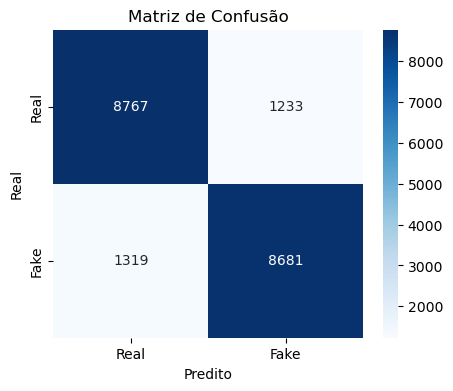


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.87      0.88      0.87     10000
        Fake       0.88      0.87      0.87     10000

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

AUC (ROC): 0.9453


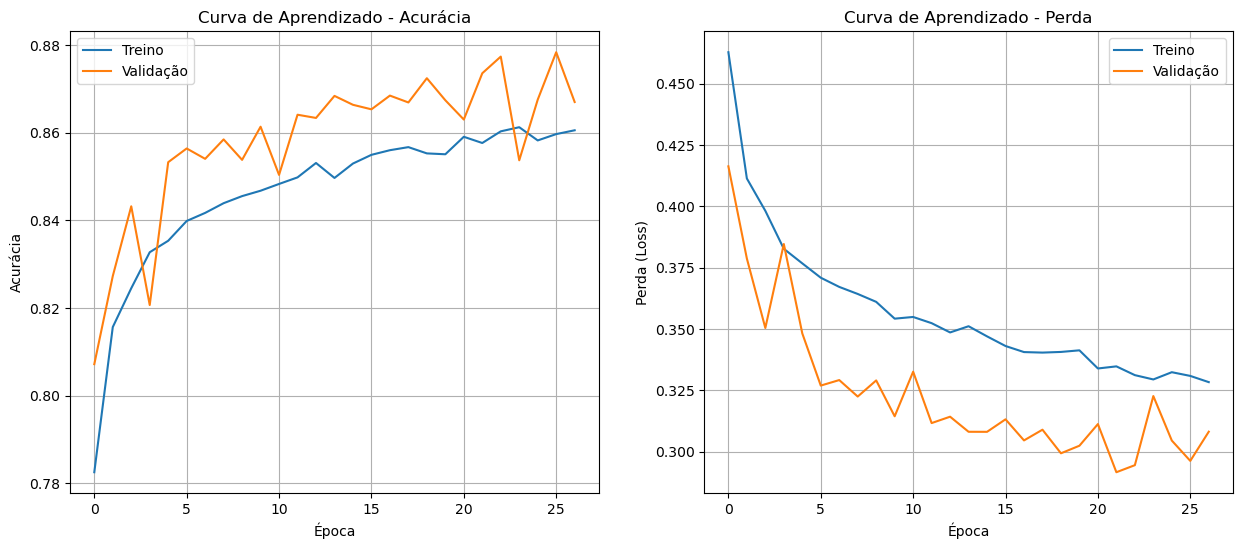

In [14]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Extrair labels verdadeiros do dataset de teste
y_test = []
for _, labels in test_ds:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Flatten y_pred_prob para garantir formato correto
y_pred_prob = y_pred_prob.ravel()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC (ROC): {roc_auc:.4f}")

plt.figure(figsize=(15, 6))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Curva de Aprendizado - Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Curva de Aprendizado - Perda")
plt.xlabel("Época")
plt.ylabel("Perda (Loss)")
plt.legend()
plt.grid()

plt.show()

In [11]:
model.save("resnet.keras")
import json
with open('history_resnet.json', 'w') as f:
    json.dump(history.history, f)